In [ ]:
# CNN-GRU Baseline for Medical VQA

This notebook implements:
- Exploratory Data Analysis (EDA)
- CNN-GRU model training
- Evaluation on closed-ended (Yes/No) questions
- Quantitative metrics (Accuracy, Precision, Recall, F1-score)
- Confusion matrix analysis
- Grad-CAM explainability

Dataset: VQA-RAD


In [1]:
import torch
print("GPU available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


GPU available: True
GPU name: Tesla T4


In [2]:
#Mounted
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os

base_path = "/content/drive/MyDrive/WOA7015_MedVQA"
os.makedirs(base_path, exist_ok=True)

print("Project directory:", base_path)


Project directory: /content/drive/MyDrive/WOA7015_MedVQA


In [4]:
import zipfile

zip_path = "/content/drive/MyDrive/VQA.zip"
extract_path = "/content/drive/MyDrive/WOA7015_MedVQA/data/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("ZIP extracted successfully!")


ZIP extracted successfully!


In [5]:
#Check dataset folder
!ls /content/drive/MyDrive/WOA7015_MedVQA/data/


 Readme.docx		       'VQA_RAD Dataset Public.xml'
'VQA_RAD Dataset Public.json'  'VQA_RAD Image Folder'
'VQA_RAD Dataset Public.xlsx'


In [6]:
#Load & Inspect the Dataset
import os
import json

base_path = "/content/drive/MyDrive/WOA7015_MedVQA/data"

image_dir = os.path.join(base_path, "VQA_RAD Image Folder")
json_path = os.path.join(base_path, "VQA_RAD Dataset Public.json")

print("Image folder exists:", os.path.exists(image_dir))
print("JSON file exists:", os.path.exists(json_path))


Image folder exists: True
JSON file exists: True


In [7]:
#Dataset Structure and Load the JSON File
with open(json_path, "r") as f:
    data = json.load(f)

print("Total QA samples:", len(data))
print("Sample entry:")
data[0]


Total QA samples: 2248
Sample entry:


{'qid': '0',
 'phrase_type': 'freeform',
 'qid_linked_id': '03f451ca-de62-4617-9679-e836026a7642',
 'image_case_url': 'https://medpix.nlm.nih.gov/case?id=48e1dd0e-8552-46ad-a354-5eb55be86de6',
 'image_name': 'synpic54610.jpg',
 'image_organ': 'HEAD',
 'evaluation': 'not evaluated',
 'question': 'Are regions of the brain infarcted?',
 'question_rephrase': 'NULL',
 'question_relation': 'NULL',
 'question_frame': 'NULL',
 'question_type': 'PRES',
 'answer': 'Yes',
 'answer_type': 'CLOSED'}

In [8]:
#Inspect One Sample
sample = data[0]

print("Image:", sample["image_name"])
print("Question:", sample["question"])
print("Answer:", sample["answer"])
print("Type:", sample["question_type"])


Image: synpic54610.jpg
Question: Are regions of the brain infarcted?
Answer: Yes
Type: PRES


In [10]:
#Question Type Distribution
def is_yes_no(ans):
    return isinstance(ans, str) and ans.lower() in ["yes", "no"]

yes_no = sum(is_yes_no(x["answer"]) for x in data)
open_ended = len(data) - yes_no

print("Yes/No questions:", yes_no)
print("Open-ended questions:", open_ended)


Yes/No questions: 1193
Open-ended questions: 1055


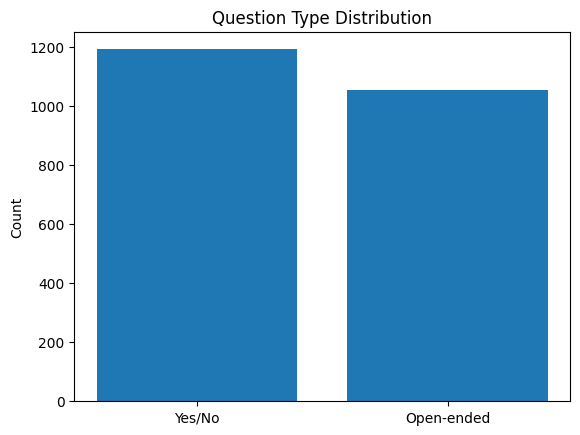

In [11]:
#bar chart
import matplotlib.pyplot as plt
plt.figure()
plt.bar(["Yes/No", "Open-ended"], [yes_no, open_ended])
plt.title("Question Type Distribution")
plt.ylabel("Count")
plt.show()


In [12]:
#Yes/No Balance
yes = sum(1 for x in data if x["answer"] == "Yes")
no  = sum(1 for x in data if x["answer"] == "No")

print("Yes:", yes)
print("No:", no)


Yes: 347
No: 486


In [13]:
#Question Length
question_lengths = [len(x["question"].split()) for x in data]

print("Avg question length:", sum(question_lengths)/len(question_lengths))
print("Min question length:", min(question_lengths))
print("Max question length:", max(question_lengths))



Avg question length: 6.814946619217082
Min question length: 3
Max question length: 22


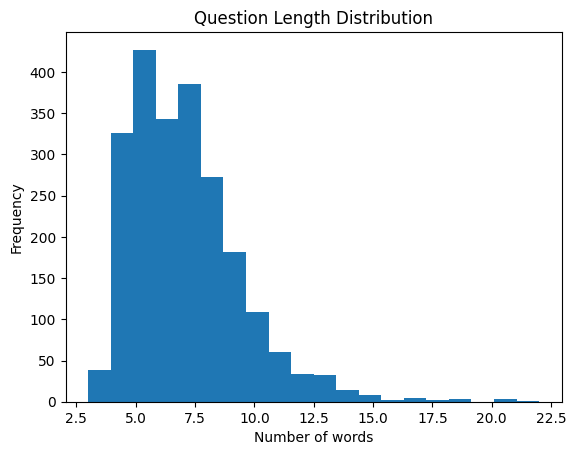

In [14]:
#Histogram
plt.figure()
plt.hist(question_lengths, bins=20)
plt.title("Question Length Distribution")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()


Question: Are regions of the brain infarcted?
Answer: Yes


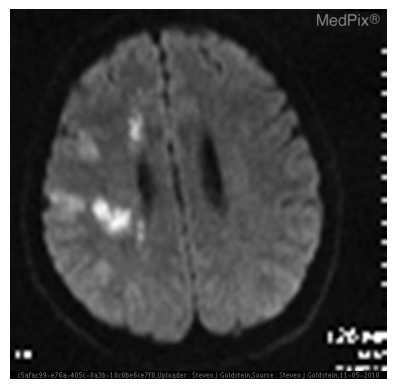

In [15]:
#sample
sample = data[0]

print("Question:", sample["question"])
print("Answer:", sample["answer"])

from PIL import Image
import os
import matplotlib.pyplot as plt

img = Image.open(os.path.join(image_dir, sample["image_name"]))
plt.imshow(img)
plt.axis("off")
plt.show()


In [16]:
#Created the Split
from sklearn.model_selection import train_test_split

# First split: Train (70%) and Temp (30%)
train_data, temp_data = train_test_split(
    data,
    test_size=0.30,
    random_state=42,
    shuffle=True
)

# Second split: Validation (15%) and Test (15%)
val_data, test_data = train_test_split(
    temp_data,
    test_size=0.50,
    random_state=42,
    shuffle=True
)

print("Train samples:", len(train_data))
print("Validation samples:", len(val_data))
print("Test samples:", len(test_data))


Train samples: 1573
Validation samples: 337
Test samples: 338


In [17]:
#Install Required Libraries
!pip install pillow torchvision


In [18]:
#Import Libraries
import os
import re
import json
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
from collections import Counter



In [19]:
#Define Image Transform
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [20]:
#Encode Questions + Padding
MAX_LEN = 20

def tokenize(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"[^a-z0-9\s]", "", sentence)
    return sentence.split()

def encode_question(question, vocab, max_len=MAX_LEN):
    tokens = tokenize(question)
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens]

    if len(encoded) < max_len:
        encoded += [vocab["<PAD>"]] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]

    return encoded


In [21]:
#Build Vocabulary
counter = Counter()
for item in train_data:
    counter.update(tokenize(item["question"]))

vocab = {
    "<PAD>": 0,
    "<UNK>": 1
}

for word in counter:
    vocab[word] = len(vocab)

print("Vocabulary size:", len(vocab))


Vocabulary size: 1019


In [22]:
#Filter Yes / No Samples
def is_yes_no(ans):
    if isinstance(ans, str):
        return ans.lower() in ["yes", "no"]
    return False

train_yn = [x for x in train_data if is_yes_no(x["answer"])]
val_yn   = [x for x in val_data if is_yes_no(x["answer"])]
test_yn  = [x for x in test_data if is_yes_no(x["answer"])]

print("Yes/No samples:")
print("Train:", len(train_yn))
print("Val:", len(val_yn))
print("Test:", len(test_yn))


Yes/No samples:
Train: 841
Val: 186
Test: 166


In [23]:
#Import DataLoader
from torch.utils.data import DataLoader


In [24]:
class VQARADDataset(Dataset):
    def __init__(self, data, image_dir, vocab, answer_map, transform=None):
        self.data = data
        self.image_dir = image_dir
        self.vocab = vocab
        self.answer_map = answer_map
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Image
        img_path = os.path.join(self.image_dir, item["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # Question
        q_encoded = encode_question(item["question"], self.vocab)
        question = torch.tensor(q_encoded, dtype=torch.long)

        # ✅ LABEL AS TENSOR (THIS FIXES EVERYTHING)
        label = torch.tensor(
            self.answer_map[item["answer"].lower()],
            dtype=torch.long
        )

        return image, question, label


In [25]:
#Define answer_to_idx
answer_to_idx = {
    "no": 0,
    "yes": 1
}

idx_to_answer = {v: k for k, v in answer_to_idx.items()}

print(answer_to_idx)


{'no': 0, 'yes': 1}


In [26]:
#Recreate Datasets
train_dataset = VQARADDataset(train_yn, image_dir, vocab, answer_to_idx, image_transform)
val_dataset   = VQARADDataset(val_yn, image_dir, vocab, answer_to_idx, image_transform)
test_dataset  = VQARADDataset(test_yn, image_dir, vocab, answer_to_idx, image_transform)


In [27]:
#Recreate DataLoaders

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [28]:
#SANITY CHECK
images, questions, labels = next(iter(train_loader))

print("Images:", images.shape)
print("Questions:", questions.shape)
print("Labels:", labels.shape)


Images: torch.Size([16, 3, 224, 224])
Questions: torch.Size([16, 20])
Labels: torch.Size([16])


In [29]:
#define the CNN-GRU Model
import torch
import torch.nn as nn
import torchvision.models as models

# Image Encoder
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = x.squeeze(-1).squeeze(-1)
        return x

# Question Encoder
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(embed_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.gru(x)
        return hidden.squeeze(0)

# CNN-GRU VQA Model
class CNN_GRU_VQA(nn.Module):
    def __init__(self, vocab_size, num_answers):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.question_encoder = QuestionEncoder(vocab_size)

        self.fc = nn.Sequential(
            nn.Linear(2048 + 512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_answers)
        )

    def forward(self, image, question):
        img_feat = self.image_encoder(image)
        ques_feat = self.question_encoder(question)
        combined = torch.cat((img_feat, ques_feat), dim=1)
        return self.fc(combined)


In [30]:
#Create the Model Object
num_answers = 2  # Yes / No
model = CNN_GRU_VQA(vocab_size=len(vocab), num_answers=num_answers)
print("Model created")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Model created


In [31]:
#Move Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print("Using device:", device)


Using device: cuda


In [32]:
#Helper: Accuracy Function
def accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)


In [33]:
#Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, questions, labels in train_loader:
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images, questions)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, questions, labels in val_loader:
                images = images.to(device)
                questions = questions.to(device)
                labels = labels.to(device)

                outputs = model(images, questions)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )


In [34]:
#Define criterion
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
print("Loss function defined")


Loss function defined


In [35]:
#Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print("Optimizer defined")


Optimizer defined


In [36]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, questions, labels in train_loader:
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, questions, labels in val_loader:
                images = images.to(device)
                questions = questions.to(device)
                labels = labels.to(device)

                outputs = model(images, questions)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}"
        )

    return history


In [37]:
history = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=6
)


Epoch [1/6] | Train Acc: 0.5852, Val Acc: 0.6188
Epoch [2/6] | Train Acc: 0.6730, Val Acc: 0.6094
Epoch [3/6] | Train Acc: 0.6815, Val Acc: 0.6594
Epoch [4/6] | Train Acc: 0.7234, Val Acc: 0.6656
Epoch [5/6] | Train Acc: 0.7440, Val Acc: 0.6937
Epoch [6/6] | Train Acc: 0.7626, Val Acc: 0.7146


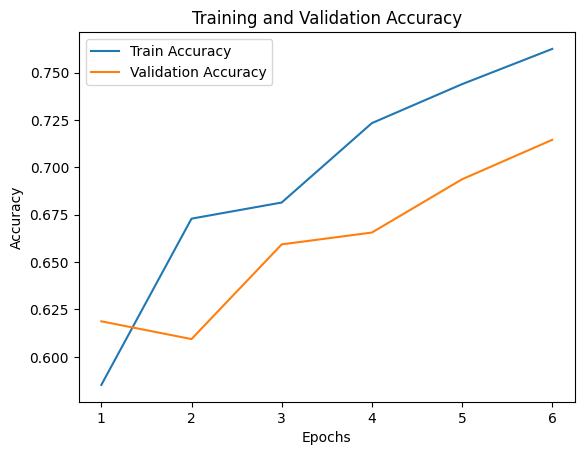

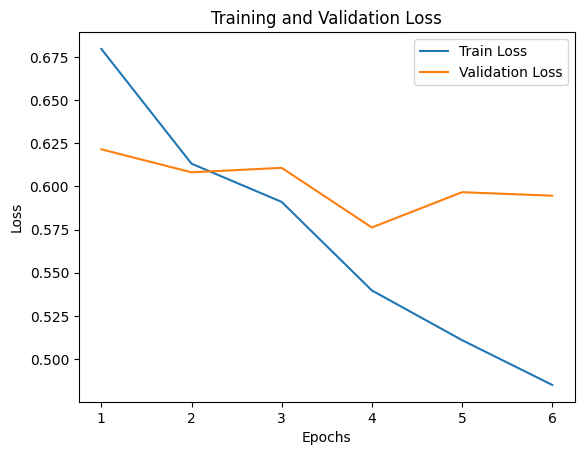

In [38]:
#Plot Accuracy & Loss
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_acc"]) + 1)

# Accuracy plot
plt.figure()
plt.plot(epochs, history["train_acc"], label="Train Accuracy")
plt.plot(epochs, history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Loss plot
plt.figure()
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


In [39]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0

    with torch.no_grad():
        for images, questions, labels in test_loader:
            images = images.to(device)
            questions = questions.to(device)
            labels = labels.to(device)

            outputs = model(images, questions)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    return test_loss, test_acc


In [40]:
test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion,
    device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.5901
Test Accuracy: 0.7197


In [41]:
sample = train_data[0]  # or test_data[0]

print(sample["image_name"])
print(sample["question"])
print(sample["answer"])


synpic57237.jpg
Is the skull fractured?
No


In [44]:
import torch
from PIL import Image
import os

model.eval()

# ---- PICK A CLOSED-ENDED SAMPLE WITH GROUND TRUTH = YES ----
sample = None
for item in test_data:
    if (
        isinstance(item["answer"], str)
        and item["answer"].lower() == "yes"
    ):
        sample = item
        break

assert sample is not None, "No YES ground-truth question found!"

image_path = os.path.join(image_dir, sample["image_name"])
question = sample["question"]

# ---- IMAGE PREPROCESSING ----
image = Image.open(image_path).convert("RGB")
image = image_transform(image).unsqueeze(0).to(device)

# ---- QUESTION ENCODING ----
question_encoded = encode_question(question, vocab)
question_tensor = torch.tensor(question_encoded).unsqueeze(0).to(device)

# ---- MODEL INFERENCE ----
with torch.no_grad():
    outputs = model(image, question_tensor)
    pred_idx = torch.argmax(outputs, dim=1).item()

pred_answer = idx_to_answer[pred_idx]

print("Question:", question)
print("Ground Truth:", sample["answer"])
print("CNN-GRU Prediction:", pred_answer)


Question: Is this MRI taken with FLAIR protocol?
Ground Truth: Yes
CNN-GRU Prediction: yes


In [43]:
import torch
from PIL import Image
import os

model.eval()

# ---- PICK ANOTHER CLOSED-ENDED (YES/NO) SAMPLE ----
sample = None
for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() in ["yes", "no"]:
        if item != test_data[0]:   # ensure it's a different question
            sample = item
            break

assert sample is not None, "No Yes/No question found!"

image_path = os.path.join(image_dir, sample["image_name"])
question = sample["question"]

# ---- IMAGE PREPROCESSING ----
image = Image.open(image_path).convert("RGB")
image = image_transform(image).unsqueeze(0).to(device)

# ---- QUESTION ENCODING ----
question_encoded = encode_question(question, vocab)
question_tensor = torch.tensor(question_encoded).unsqueeze(0).to(device)

# ---- MODEL INFERENCE ----
with torch.no_grad():
    outputs = model(image, question_tensor)
    pred_idx = torch.argmax(outputs, dim=1).item()

pred_answer = idx_to_answer[pred_idx]

print("Question:", question)
print("Ground Truth:", sample["answer"])
print("CNN-GRU Prediction:", pred_answer)


Question: Is the bowel distended?
Ground Truth: No
CNN-GRU Prediction: no


In [45]:
# DEMONSTRATION ONLY — NOT FOR EVALUATION

model.eval()

sample = test_data[0]  # any sample (image must exist)
image_path = os.path.join(image_dir, sample["image_name"])

open_question = "What abnormality is visible in the image?"

# Image
image = Image.open(image_path).convert("RGB")
image = image_transform(image).unsqueeze(0).to(device)

# Question
question_encoded = encode_question(open_question, vocab)
question_tensor = torch.tensor(question_encoded).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image, question_tensor)
    pred_idx = torch.argmax(outputs, dim=1).item()

pred_answer = idx_to_answer[pred_idx]

print("Open-ended Question:", open_question)
print("CNN-GRU Output:", pred_answer)


Open-ended Question: What abnormality is visible in the image?
CNN-GRU Output: yes


In [46]:
#Collect Predictions and Ground Truth
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for images, questions, labels in test_loader:
        images = images.to(device)
        questions = questions.to(device)
        labels = labels.to(device)

        outputs = model(images, questions)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [47]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[60 25]
 [21 60]]


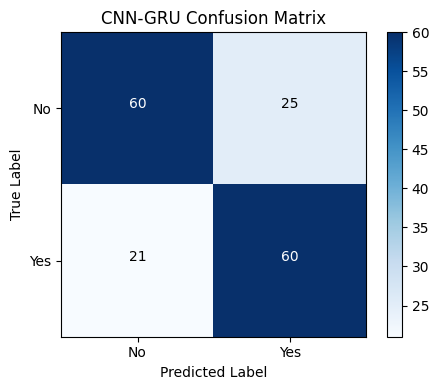

In [48]:
#Confusion Matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("CNN-GRU Confusion Matrix")
plt.colorbar()

classes = ["No", "Yes"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
from PIL import Image
import os

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for item in test_data:
        if isinstance(item["answer"], str) and item["answer"].lower() in ["yes", "no"]:

            # Ground truth
            gt = answer_to_idx[item["answer"].lower()]
            y_true.append(gt)

            # Load image
            image_path = os.path.join(image_dir, item["image_name"])
            image = Image.open(image_path).convert("RGB")
            image = image_transform(image).unsqueeze(0).to(device)

            # Encode question
            question_encoded = encode_question(item["question"], vocab)
            question_tensor = torch.tensor(question_encoded).unsqueeze(0).to(device)

            # Model prediction
            outputs = model(image, question_tensor)
            pred = torch.argmax(outputs, dim=1).item()
            y_pred.append(pred)


In [50]:
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print("CNN-GRU Test Accuracy:", acc)
print("CNN-GRU Precision:", prec)
print("CNN-GRU Recall:", rec)
print("CNN-GRU F1-score:", f1)
print("Confusion Matrix:\n", cm)


CNN-GRU Test Accuracy: 0.7228915662650602
CNN-GRU Precision: 0.7058823529411765
CNN-GRU Recall: 0.7407407407407407
CNN-GRU F1-score: 0.7228915662650602
Confusion Matrix:
 [[60 25]
 [21 60]]


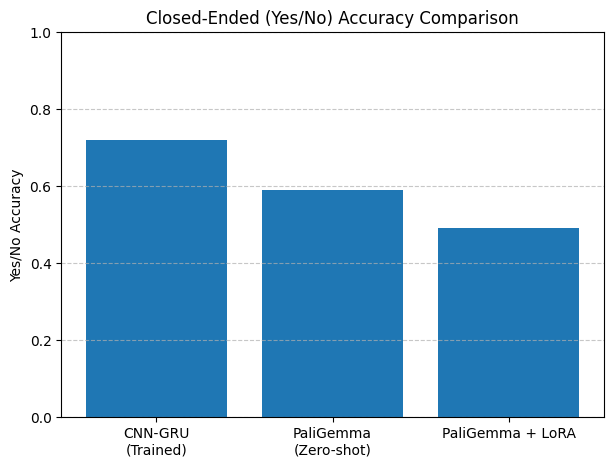

In [52]:
#Closed-Ended Accuracy Comparison
import matplotlib.pyplot as plt

models = [
    "CNN-GRU\n(Trained)",
    "PaliGemma\n(Zero-shot)",
    "PaliGemma + LoRA"
]

accuracies = [
    0.72,   # CNN-GRU
    0.59,   # PaliGemma zero-shot
    0.49    # PaliGemma + LoRA (final)
]

plt.figure(figsize=(7,5))
plt.bar(models, accuracies)
plt.ylabel("Yes/No Accuracy")
plt.ylim(0, 1)
plt.title("Closed-Ended (Yes/No) Accuracy Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


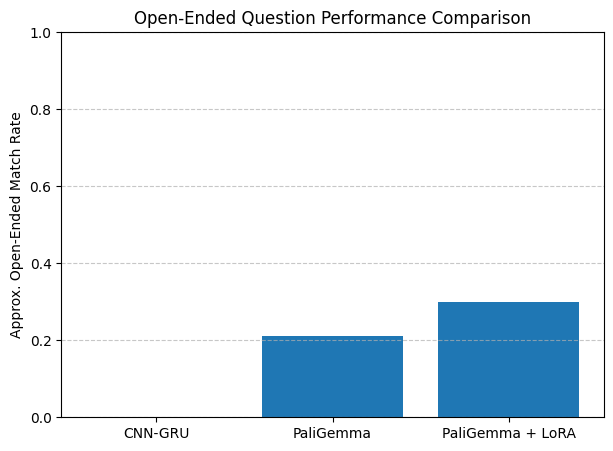

In [53]:
#Open-Ended Ability
models = ["CNN-GRU", "PaliGemma", "PaliGemma + LoRA"]
open_ended_scores = [0.0, 0.21, 0.30]  # approx keyword match / qualitative

plt.figure(figsize=(7,5))
plt.bar(models, open_ended_scores)
plt.ylabel("Approx. Open-Ended Match Rate")
plt.ylim(0, 1)
plt.title("Open-Ended Question Performance Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [54]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os


In [55]:
model.eval()

sample = None
for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() in ["yes", "no"]:
        sample = item
        break

assert sample is not None, "No Yes/No sample found!"

image_path = os.path.join(image_dir, sample["image_name"])
question = sample["question"]


In [56]:
# Image
image = Image.open(image_path).convert("RGB")
image_tensor = image_transform(image).unsqueeze(0).to(device)

# Question
question_encoded = encode_question(question, vocab)
question_tensor = torch.tensor(question_encoded).unsqueeze(0).to(device)


In [58]:
import torch
from PIL import Image
import os

model.eval()

# ---- PICK A CLOSED-ENDED SAMPLE WITH GROUND TRUTH = YES ----
sample = None
for item in test_data:
    if isinstance(item["answer"], str) and item["answer"].lower() == "yes":
        sample = item
        break

assert sample is not None, "No YES ground-truth sample found!"

image_path = os.path.join(image_dir, sample["image_name"])
question = sample["question"]

# ---- IMAGE PREPROCESSING ----
image = Image.open(image_path).convert("RGB")
image_tensor = image_transform(image).unsqueeze(0).to(device)

# ---- QUESTION ENCODING ----
question_encoded = encode_question(question, vocab)
question_tensor = torch.tensor(question_encoded).unsqueeze(0).to(device)

# ---- MODEL INFERENCE ----
with torch.no_grad():
    outputs = model(image_tensor, question_tensor)
    pred_idx = torch.argmax(outputs, dim=1).item()

pred_answer = idx_to_answer[pred_idx]

print("Question:", question)
print("Ground Truth:", sample["answer"])
print("CNN-GRU Prediction:", pred_answer)


Question: Is this MRI taken with FLAIR protocol?
Ground Truth: Yes
CNN-GRU Prediction: yes


In [59]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, image, question_tensor, class_idx):
        self.model.zero_grad()

        outputs = self.model(image, question_tensor)
        score = outputs[:, class_idx]
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()

        return cam.detach().cpu().numpy()[0]


In [60]:
# Enable training mode temporarily (required for GRU backward)
model.train()

# Disable cuDNN to avoid RNN backward error
cudnn.enabled = False


In [61]:
target_layer = model.image_encoder.features[7][2].conv3
gradcam = GradCAM(model, target_layer)


In [62]:
cam = gradcam.generate(image_tensor, question_tensor, pred_idx)
cam = cv2.resize(cam, (224, 224))


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


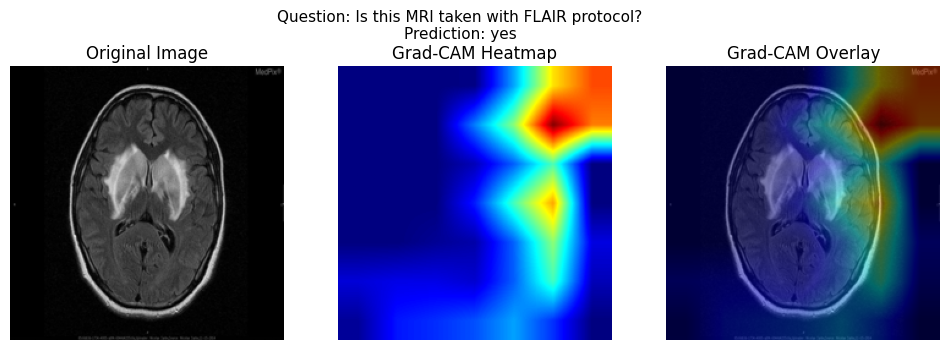

In [63]:
# Original image
original_img = image.resize((224, 224))
original_img = np.array(original_img) / 255.0

# Heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = heatmap[:, :, ::-1] / 255.0

# Overlay
overlay = 0.6 * original_img + 0.4 * heatmap
overlay = np.clip(overlay, 0, 1)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("Original Image")
plt.imshow(original_img)
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap)
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Grad-CAM Overlay")
plt.imshow(overlay)
plt.axis("off")

plt.suptitle(f"Question: {question}\nPrediction: {pred_answer}", fontsize=11)
plt.show()
